In [7]:
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import statsmodels.api as sm
from scipy import stats

# Load the dataset
####(we have uploaded the dataset on our github repository and used it here)

In [8]:
airbnb = pd.read_csv("https://raw.githubusercontent.com/kratos2597/Airbnb/main/AB_NYC_2019.csv?token=AMID5XNLN3B2ORJ6EI24J527TUGXS")
airbnb.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [9]:
### Check datatypes

airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [10]:
### Checking Null Values
airbnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Let's replace reviews per month Nan by zero and null name and host name by NoName. Also, replace last review with "Not Reviewed".

In [11]:
airbnb.fillna({'reviews_per_month':0},inplace=True)
airbnb.fillna({'name':"NoName"},inplace=True)
airbnb.fillna({'host_name':"NoName"},inplace=True)
airbnb.fillna({'last_review':"NotReviewed"},inplace=True)

In [12]:
airbnb.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [13]:
### Price Column
airbnb["price"].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

We noticed that the average price is 152 and the price varies from 0 - 10K

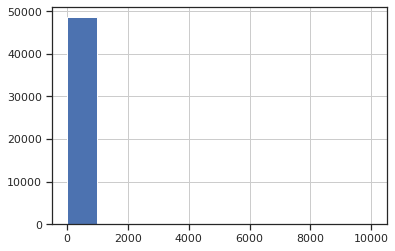

In [14]:
hist_price=airbnb["price"].hist()
### We observe that most listings have price less than $1000

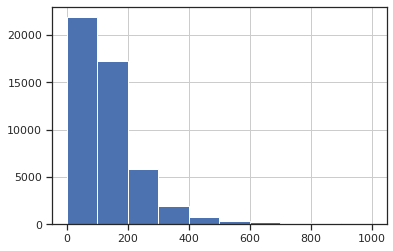

In [15]:
### Let's plot histogram for prices less tha $2000
hist_price1=airbnb["price"][airbnb["price"]<1000].hist()

In [16]:
### Listings having price more than 1k
airbnb[airbnb["price"]>1000]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
496,174966,Luxury 2Bed/2.5Bath Central Park View,836168,Henry,Manhattan,Upper West Side,40.77350,-73.98697,Entire home/apt,2000,30,30,2018-05-05,0.33,11,0
762,273190,6 Bedroom Landmark West Village Townhouse,605463,West Village,Manhattan,West Village,40.73301,-74.00268,Entire home/apt,1300,5,28,2018-09-25,0.31,4,297
946,363673,Beautiful 3 bedroom in Manhattan,256239,Tracey,Manhattan,Upper West Side,40.80142,-73.96931,Private room,3000,7,0,NotReviewed,0.00,1,365
1105,468613,$ (Phone number hidden by Airbnb) weeks - room f,2325861,Cynthia,Manhattan,Lower East Side,40.72152,-73.99279,Private room,1300,1,0,NotReviewed,0.00,1,0
1480,664047,Lux 2Bed/2.5Bath Central Park Views,836168,Henry,Manhattan,Upper West Side,40.77516,-73.98573,Entire home/apt,2000,30,59,2016-01-28,0.71,11,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48080,36074198,Luxury apartment 2 min to times square,203565865,Vinícius,Manhattan,SoHo,40.72060,-74.00023,Entire home/apt,1308,2,0,NotReviewed,0.00,1,179
48304,36189195,Next to Times Square/Javits/MSG! Amazing 1BR!,270214015,Rogelio,Manhattan,Hell's Kitchen,40.75533,-73.99866,Entire home/apt,2999,30,0,NotReviewed,0.00,1,222
48305,36189257,2BR Near Museum Mile! Upper East Side!,272166348,Mary Rotsen,Manhattan,Upper East Side,40.78132,-73.95262,Entire home/apt,1999,30,0,NotReviewed,0.00,1,270
48523,36308562,"Tasteful & Trendy Brooklyn Brownstone, near Train",217732163,Sandy,Brooklyn,Bedford-Stuyvesant,40.68767,-73.95805,Entire home/apt,1369,1,0,NotReviewed,0.00,1,349


239 listings have price per day > 1000. These are either super lavish listings or there was an error during input. Nonetheless, since this records are skewing our data a lot, we will treat them as outliers and drop them.

In [17]:
airbnb = airbnb[airbnb['price']<1000]

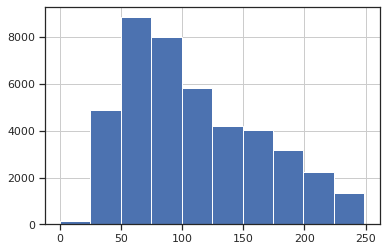

In [18]:
### We see a more Gaussian distribution here
hist_price2 = airbnb["price"][airbnb["price"]<250].hist()

In [19]:
### We use 250 as threshold price 
airbnb = airbnb[airbnb["price"]<250]

In [20]:
### Looking at the price column again
airbnb["price"].describe()

count    42669.000000
mean       107.897748
std         53.803457
min          0.000000
25%         65.000000
50%         99.000000
75%        150.000000
max        249.000000
Name: price, dtype: float64

We see that the average price is 107. Price varies between 0 to 249

In [21]:
###There are 221 unique neighbourhoods in NYC as per this data set. Most listings are in Williamsburg
airbnb['neighbourhood'].value_counts()

Bedford-Stuyvesant    3560
Williamsburg          3451
Harlem                2487
Bushwick              2404
Upper West Side       1570
                      ... 
Rossville                1
Willowbrook              1
Neponsit                 1
Richmondtown             1
New Dorp                 1
Name: neighbourhood, Length: 219, dtype: int64

In [22]:
### Count how many neighbourhoods appear more than 200
dfnh = airbnb.groupby("neighbourhood").filter(lambda x: x["neighbourhood"].count()>200)
dfnh

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NotReviewed,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NotReviewed,0.00,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NotReviewed,0.00,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NotReviewed,0.00,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NotReviewed,0.00,6,2


In [23]:
### Most data is covered 
len(dfnh["neighbourhood"])

36106

In [24]:
### Count how many neighbourhoods appear only once
dfnh = airbnb.groupby("neighbourhood").filter(lambda x: x['neighbourhood'].count() == 1)
len(dfnh["neighbourhood"])

5

In [25]:
###Lets look at neighbourhood groups
airbnb['neighbourhood_group'].value_counts()

Brooklyn         18581
Manhattan        17270
Queens            5413
Bronx             1052
Staten Island      353
Name: neighbourhood_group, dtype: int64

There are five major neighbourhood groups in NYC with Manhattan and Brooklyn accounting for 85% of the listings

In [26]:
### Lets see the average listing price by neighbourhood group
ng_price = airbnb.groupby("neighbourhood_group")["price"].mean()

In [27]:
### Manhattan is most expensive and Bronx is the least expensive place to live
ng_price

neighbourhood_group
Bronx             73.796578
Brooklyn          98.068134
Manhattan        128.670990
Queens            83.639941
Staten Island     82.606232
Name: price, dtype: float64

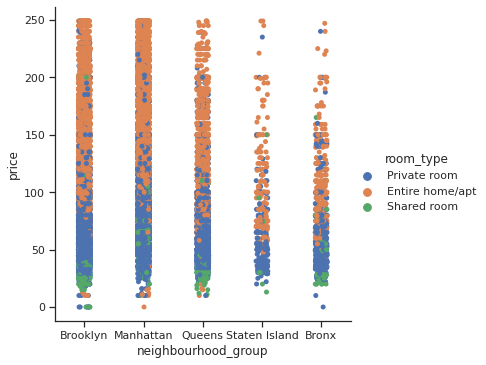

In [28]:
### Lets see the distribution of price and neighbourhood group
plott=sns.catplot(x="neighbourhood_group",y="price",hue="room_type", kind="strip", data=airbnb)
plott

Here we can note that Brooklyn and Manhattan tend to have more listings with price>150. We also note that most listings above price>100 are entire home type followed by private room and shared room which is the cheapest.

In [29]:
### Checking if there are duplicate host_ids and what is the maximum number of listings per host_id
df = airbnb.groupby(["host_id"])
df.size()                                                                

host_id
2438         1
2571         1
2787         6
2845         2
2868         1
            ..
274273284    1
274298453    1
274307600    1
274311461    1
274321313    1
Length: 32978, dtype: int64

In [30]:
max(df.size())

238

In [31]:
### Here we can see that 32K host_ids are unique appearing only once whereas some host_ids appear as much as 238 times
df.size().value_counts().head()

1    28391
2     2993
3      844
4      302
5      151
dtype: int64

In [32]:
df.size().value_counts().tail()

45     1
30     1
238    1
16     1
87     1
dtype: int64

In [33]:
### Finding the host_id with maximum listings
host_id_counts = airbnb["host_id"].value_counts()
max_host = host_id_counts.idxmax()
max_host

219517861

In [34]:
### We see that Sonder(NYC) has the max number of listings
airbnb[airbnb["host_id"]==219517861]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
38294,30181945,Sonder | 180 Water | Premier 1BR + Rooftop,219517861,Sonder (NYC),Manhattan,Financial District,40.70771,-74.00641,Entire home/apt,229,29,1,2019-05-29,0.73,327,219
38588,30347708,Sonder | 180 Water | Charming 1BR + Rooftop,219517861,Sonder (NYC),Manhattan,Financial District,40.70743,-74.00443,Entire home/apt,232,29,1,2019-05-21,0.60,327,159
39771,30937594,Sonder | The Nash | Brilliant Studio + Rooftop,219517861,Sonder (NYC),Manhattan,Murray Hill,40.74845,-73.97446,Entire home/apt,245,2,4,2019-06-08,0.94,327,137
39772,30937595,Sonder | 11th Ave | Bright 1BR + Gym,219517861,Sonder (NYC),Manhattan,Hell's Kitchen,40.76188,-73.99616,Entire home/apt,185,29,1,2019-06-20,1.00,327,281
39773,30937596,Sonder | 11th Ave | Contemporary 1BR + Gym,219517861,Sonder (NYC),Manhattan,Hell's Kitchen,40.76037,-73.99744,Entire home/apt,185,29,1,2019-06-10,1.00,327,332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47686,35869234,Sonder | 116 John | Classic 1BR + Gym,219517861,Sonder (NYC),Manhattan,Financial District,40.70852,-74.00510,Entire home/apt,198,29,0,NotReviewed,0.00,327,345
47687,35869466,Sonder | 116 John | Classic Studio + Gym,219517861,Sonder (NYC),Manhattan,Financial District,40.70802,-74.00642,Entire home/apt,180,29,0,NotReviewed,0.00,327,338
47691,35871510,Sonder | 116 John | Vibrant Studio + Fitness Room,219517861,Sonder (NYC),Manhattan,Financial District,40.70818,-74.00631,Entire home/apt,135,29,0,NotReviewed,0.00,327,339
47692,35871511,Sonder | 116 John | Vibrant 1BR + Fitness Room,219517861,Sonder (NYC),Manhattan,Financial District,40.70691,-74.00682,Entire home/apt,165,29,0,NotReviewed,0.00,327,342


Listing id and Host name are not useful for our analysis so I will drop them

In [35]:
airbnb = airbnb.drop(columns = ["id","host_name"])

In [36]:
### Let's Analyse the listing name column
airbnb["name_length"]=airbnb['name'].map(str).apply(len)

In [37]:
###Max and Min name length
print(airbnb["name_length"].max())
print(airbnb["name_length"].min())
print(airbnb["name_length"].idxmax())
print(airbnb["name_length"].idxmin())

179
1
25832
4033


In [38]:
### Max name
airbnb.at[25832,'name']

'The printing studio bedroom with garden in Bedstuy  !!Brooklyn. Historic neighborhood close to everything ! Full kitchen bathroom BBQ and porch at your disposal. Learn to print !!'

In [39]:
airbnb.at[4022,'name']

'Gorgeous Apartment in Battery Park!'

In [40]:
airbnb.at[4033,'name']

'/'

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


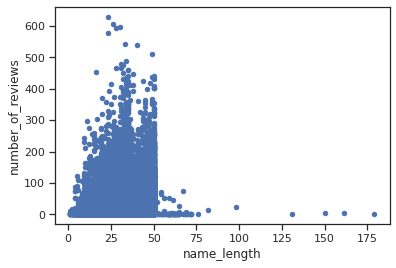

In [41]:
### Let's figure if name length has an impact on how much it is noticed.
###We can assume higher number of reviews mean more people lived there 
###and hence more people "noticed" the listing
airbnb.plot.scatter(x='name_length', y="number_of_reviews")

In [42]:
airbnb["name_length"].corr(airbnb["number_of_reviews"]) 

-0.004684119349132562

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


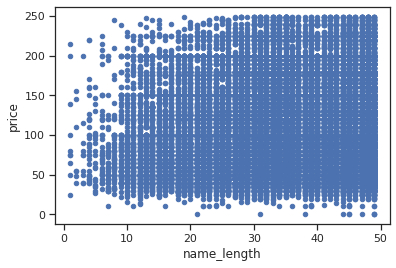

In [43]:
###There is hardly any relationship there. Lets try between price and name length 
airbnb[airbnb["name_length"]<50].plot.scatter(x="name_length", y ="price")

In [44]:
airbnb["name_length"].corr(airbnb["price"])

0.056295731411209415

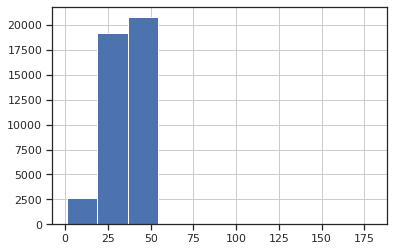

In [45]:
airbnb.name_length.hist()

In [46]:
### Lets look at room_type variable
airbnb['room_type'].value_counts()
### Most listings are either Entire home or Private room

Private room       21753
Entire home/apt    19790
Shared room         1126
Name: room_type, dtype: int64

In [47]:
### Average price per room_type
rt_price = airbnb.groupby("room_type")["price"].mean()
rt_price

room_type
Entire home/apt    144.977211
Private room        76.802832
Shared room         56.925400
Name: price, dtype: float64

In [48]:
### Analysing minimum nights
airbnb["minimum_nights"].describe()

count    42669.000000
mean         6.856359
std         19.981924
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

Again, range is between 1 night to 1250 nights. Quite odd.

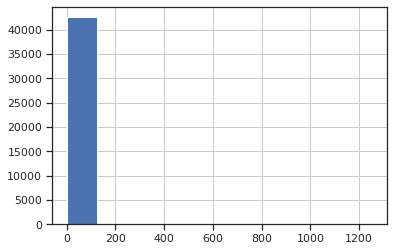

In [49]:
### Analysing minimum nights
### We see most values are between 1 to 100
hist_mn=airbnb["minimum_nights"].hist()
hist_mn

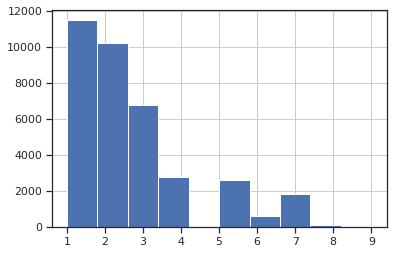

In [50]:
### Closer look
hist_mn1=airbnb["minimum_nights"][airbnb["minimum_nights"]<10].hist()
hist_mn1

In [51]:
airbnb["minimum_nights"][airbnb['minimum_nights']>30]

6         45
14        90
36        60
81        31
106       90
        ... 
48312     90
48325     60
48368     60
48446    365
48752     32
Name: minimum_nights, Length: 628, dtype: int64

In [52]:
### We replace all records with min nights > 30 by 30
airbnb.loc[(airbnb.minimum_nights >30),"minimum_nights"]=30

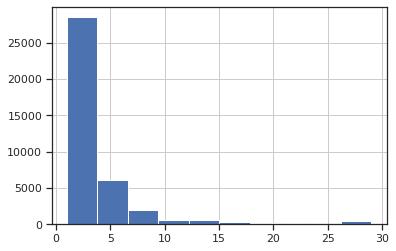

In [53]:
hist_mn2=airbnb["minimum_nights"][airbnb["minimum_nights"]<30].hist()
hist_mn2

In [54]:
### Does minimum_nights have impact on price?
airbnb["minimum_nights"].corr(airbnb["price"])

0.059554361719124246

In [55]:
###now lets analyse availability_365 column
airbnb["availability_365"].describe()

count    42669.000000
mean       107.622747
std        129.731981
min          0.000000
25%          0.000000
50%         37.000000
75%        211.000000
max        365.000000
Name: availability_365, dtype: float64

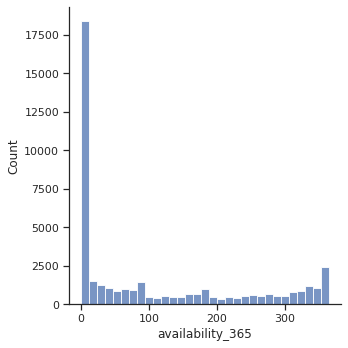

In [56]:
sns.displot(airbnb['availability_365'])

In [57]:
### After analysis, We have decided to drop these columns as they will not be useful in prediction
airbnb.drop(["name",'last_review',"latitude",'longitude'], axis=1, inplace=True)

In [58]:
### Dropping host_id
airbnb.drop(["host_id"], axis=1, inplace=True)

Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'name_length'],
      dtype='object')

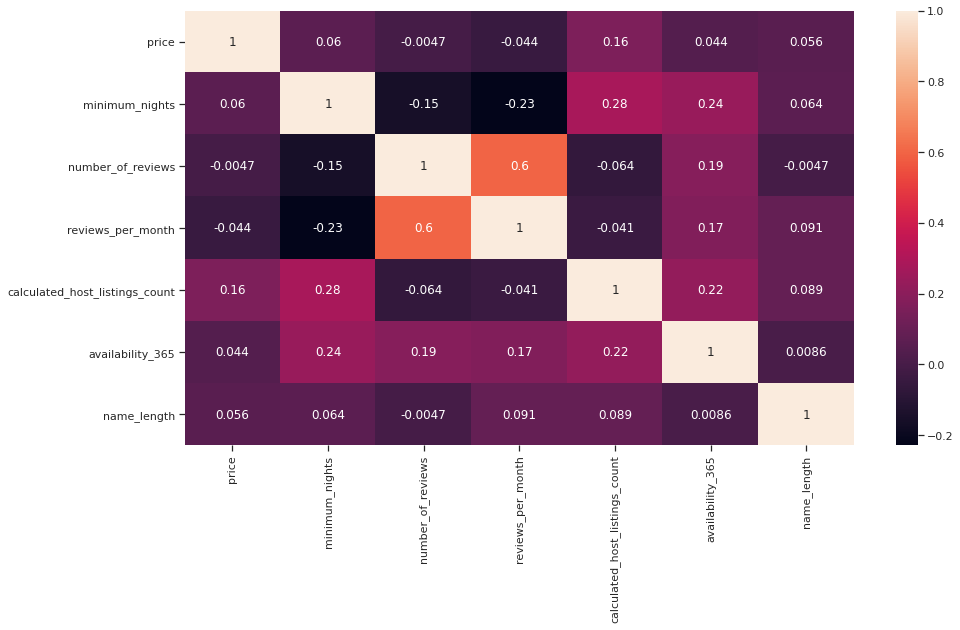

In [59]:
### Plotting correlation matrix 
corr = airbnb.corr(method='pearson')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
airbnb.columns

In [60]:
### Lets check out data one more time before beginning prediction.
airbnb.dtypes

neighbourhood_group                object
neighbourhood                      object
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
name_length                         int64
dtype: object

## Let us start with basic Linear Regression to create a base line model

Making dummies for neighbourhood group and room_type

In [61]:
## without neighbourhood column

dataset_onehot1 = pd.get_dummies(airbnb, columns=['neighbourhood_group',"room_type"], prefix = ['ng',"rt"],drop_first=True)
dataset_onehot1.drop(["neighbourhood"], axis=1, inplace=True)

In [62]:
### Checking dataframe shape
dataset_onehot1.shape

(42669, 13)

In [63]:
X1= dataset_onehot1.loc[:, dataset_onehot1.columns != 'price']

In [64]:
Y1 = dataset_onehot1["price"]

Splitting Data into Training and testing data 

In [65]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.20, random_state=42)

In [66]:
### Fitting Linear regression
reg1 = LinearRegression().fit(x_train1, y_train1)

In [67]:
### R squared value
reg1.score(x_train1, y_train1)

0.5033306680968379

In [68]:
### Coefficients
reg1.coef_

array([-8.09520215e-01, -9.08803421e-03, -1.61641699e+00,  1.42434665e-01,
        4.67863558e-02,  1.98696542e-01,  1.98040033e+01,  4.41704660e+01,
        9.69056189e+00,  2.05907986e-01, -6.56442414e+01, -8.90902274e+01])

In [69]:
### Predicting 
y_pred1 = reg1.predict(x_test1)

In [70]:
Coeff1 = pd.DataFrame(columns=["Variable","Coefficient"])
Coeff1["Variable"]=x_train1.columns
Coeff1["Coefficient"]=reg1.coef_
Coeff1.sort_values("Coefficient")

,Variable,Coefficient
11,rt_Shared room,-89.090227
10,rt_Private room,-65.644241
2,reviews_per_month,-1.616417
0,minimum_nights,-0.809520
1,number_of_reviews,-0.009088
4,availability_365,0.046786
3,calculated_host_listings_count,0.142435
5,name_length,0.198697
9,ng_Staten Island,0.205908
8,ng_Queens,9.690562


In [71]:
### Calculate RMSE
rmse1 = np.sqrt(metrics.mean_squared_error(y_test1, y_pred1))
rmse1

37.68798547656789

In [72]:
### Taking a closer look at the estimates
X2 = sm.add_constant(x_train1)
est = sm.OLS(y_train1, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     2882.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:09:23   Log-Likelihood:            -1.7259e+05
No. Observations:               34135   AIC:                         3.452e+05
Df Residuals:                   34122   BIC:                         3.453e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Model Interpretation
Now that we have the results of our model, lets try to interpret it in detail.




1.   We first look at the Adjusted R square value since this is a Multiple linear regression. It tell us that our independent variables can explain 50.3% of variations in our dependent variable, which is price.
The constant or the y intercept has a value of 109.56. This means that putting all other x variables at 0, an Entire Apt/Home in Bronx will have a predicted price of 109.56. Remember when we created dummy variables we dropped one dummy from each column which we use as reference.
2.   Let's now look at the coefficients. The coefficient of ng_Manhattan is 44.09. We interpret as: Everything else being constant, an Entire Apt/ Home in Manhattan will cost 44.09 more that same in Bronx. We can similarly interpret coefficient of minimum night as: With everything else being constant, with every one unit increase in minimum number of nights, the predicted price decreases by 0.8075.
The std error is nothing but sample standard deviation for each variable. the t column shows the value of t statistic which is the z score of the sample variable. Z score tells us how far a sample is from its mean. A Z score of 2 tells us that the sample is two standard deviation away from the mean.
P values suggests how significant these estimates are. Considering 

1.   alpha of 0.05, we can reject the Null hypothesis for all variables except number_of_reviews, and ng_Staten Island. Alpha is the degree of error we are willing to accept. we have chosen alpha as 5% which is also most commonly used.
4. The confidence intervals show the upper bound and lower bound for the TRUE POPULATION coefficient with 95% confidence.

## Lets try to use the neighbourhood variable. It has more than 200 distinct values.
Hence, when we create dummies we will have large number of variables.

In [73]:
dataset_onehot2 = pd.get_dummies(airbnb, columns=['neighbourhood_group',"neighbourhood","room_type"], prefix = ['ng',"nh","rt"],drop_first=True)

In [74]:
dataset_onehot2.shape

(42669, 231)

In [75]:
XL1 = dataset_onehot2.loc[:,dataset_onehot2.columns !='price']
YL1 = dataset_onehot2["price"]
x_trainL11, x_testL11, y_trainL11, y_testL11 = train_test_split(XL1,YL1,test_size=0.20, random_state=42)

We will use Lasso regression because it has the ability to nullify parameters that do not improve the model. Also, the dataset isn't large enough and hence Lasso is a good choice as it would add a little bit bias but reduce variance greatly. Starting with alpha=0.1 We can use crossvalidation and check for many values for alpha to find best one, but I will save this process for the next model which I think will procduce better results.

In [76]:
regL1 = Lasso(alpha=0.01)
regL1.fit(x_trainL11,y_trainL11)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [77]:
### R Squared
### This regularised model did way better than the normal regresion
regL1.score(x_trainL11, y_trainL11)

0.5672687881098055

In [78]:
### RMSE
### Smaller value than earlier
y_predL1= regL1.predict(x_testL11)
print(np.sqrt(metrics.mean_squared_error(y_testL11,y_predL1)))

35.122928878780456


In [79]:
### We can see that some parameters have zero coefficients.
regL1.coef_

array([-8.74108236e-01, -1.54617057e-02, -1.21937375e+00,  8.53509662e-02,
        5.35827161e-02,  1.33032667e-01,  1.25894104e+01,  5.02217532e+01,
        6.30345411e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  7.63815202e+00, -0.00000000e+00,  0.00000000e+00,
       -5.54357765e-01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.14970076e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.25171095e+00, -0.00000000e+00,
        2.15210517e+01, -1.25645271e+01,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -3.46151208e+00,  2.93815492e+01, -4.40132764e+00,
        0.00000000e+00, -1.35292724e+00,  0.00000000e+00, -7.53591116e+00,
        2.39801650e+01, -0.00000000e+00,  0.00000000e+00,  1.25661957e+01,
       -6.68172734e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  1.77925788e+01,  0.00000000e+00,
        2.19739411e+01, -

In [80]:
CoeffLS1 = pd.DataFrame(columns=["Variable","Coefficients"])
CoeffLS1["Variable"]=x_trainL11.columns
CoeffLS1["Coefficients"]=regL1.coef_
CoeffLS1.sort_values("Coefficients", ascending = False)

,Variable,Coefficients
7,ng_Manhattan,50.221753
212,nh_Vinegar Hill,32.472285
62,nh_DUMBO,32.424046
34,nh_Brooklyn Heights,29.381549
66,nh_Downtown Brooklyn,25.408918
...,...,...
102,nh_Harlem,-26.649650
214,nh_Washington Heights,-38.861157
111,nh_Inwood,-40.219526
228,rt_Private room,-61.689711


### Finally, lets try Random forest regressor which we believe will give best results


In [81]:
### Initially, lets build a tree without any constraints.
regrRM = RandomForestRegressor(n_estimators=300)
regrRM.fit(x_trainL11, y_trainL11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [82]:
### We get R squared value as 93.6%! There is obviously a problem of overfitting.

print(regrRM.score(x_trainL11, y_trainL11))
y_predL1= regrRM.predict(x_testL11)
print(np.sqrt(metrics.mean_squared_error(y_testL11,y_predL1)))

0.9359121650375394
34.90212188870185


In [83]:
### Using feature importance, we can see which feature had most weight
regrRM.feature_importances_

array([5.21229895e-02, 5.79542097e-02, 7.71462916e-02, 3.75438186e-02,
       7.35108942e-02, 8.47088470e-02, 3.87133894e-03, 6.09536989e-02,
       1.32886140e-03, 2.66828904e-04, 8.95160565e-07, 1.13023617e-04,
       2.79149916e-04, 1.21163019e-03, 2.05319107e-05, 2.24012375e-04,
       6.70798041e-04, 4.41716441e-05, 1.81199418e-05, 3.67490290e-06,
       2.02250042e-04, 6.75016841e-05, 3.03067580e-03, 4.37163822e-04,
       3.87236435e-05, 2.55582854e-04, 2.45778155e-04, 1.59549327e-04,
       7.78876785e-04, 2.88886045e-04, 1.24996565e-04, 3.24568060e-04,
       2.63478755e-04, 2.09973759e-05, 1.46018151e-03, 1.53241882e-04,
       6.78170841e-06, 2.37760165e-03, 9.01403738e-05, 4.21330564e-04,
       1.39839365e-03, 1.68065431e-05, 6.24816209e-05, 2.58892417e-03,
       9.56412887e-04, 5.81976485e-05, 2.30318521e-04, 1.01352472e-04,
       9.35947159e-06, 1.39645968e-04, 1.93206544e-03, 1.18816993e-06,
       5.00061650e-04, 5.00737343e-05, 2.52582216e-04, 1.14288005e-04,
      

In [84]:
CoeffRM1 = pd.DataFrame(columns=["Variable","FeatureImportance"])
CoeffRM1["Variable"]=x_trainL11.columns
CoeffRM1["FeatureImportance"]=regrRM.feature_importances_
CoeffRM1.sort_values("FeatureImportance", ascending = False)

,Variable,FeatureImportance
228,rt_Private room,3.485162e-01
5,name_length,8.470885e-02
2,reviews_per_month,7.714629e-02
4,availability_365,7.351089e-02
229,rt_Shared room,6.669918e-02
...,...,...
219,nh_Westerleigh,3.676268e-07
78,nh_Eltingville,3.540459e-07
185,nh_Silver Lake,2.433117e-07
216,nh_West Farms,0.000000e+00


In [85]:
regrRM.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Lets see what we can do to prevent overfitting

1. We will set max depth to 50. This ensures that branching stops after 
50th branching, otherwise each sample may have its branch and overfit.
2. We will use min_samples_split as 5. The default value is 2. This means that each internal node will split as long as it has a minimum of two sample. We dont want that!
3. We will use min_samples_leaf as 4. The default is 1. This means that a node is considered leaf node if it has just one sample. This can cause severe overfitting!

In [86]:
regrRM2 = RandomForestRegressor(n_estimators=200, max_depth = 50, min_samples_split = 5,min_samples_leaf =4)
regrRM2.fit(x_trainL11, y_trainL11)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [87]:
### We get a smaller value for R squared
print(regrRM2.score(x_trainL11, y_trainL11))
y_predL1= regrRM2.predict(x_testL11)
print(np.sqrt(metrics.mean_squared_error(y_testL11,y_predL1)))

0.7976269601486193
34.346604598649385


In [88]:
CoeffRM2 = pd.DataFrame(columns=["Variable","FeatureImportance"])
CoeffRM2["Variable"]=x_trainL11.columns
CoeffRM2["FeatureImportance"]=regrRM2.feature_importances_
CoeffRM2.sort_values("FeatureImportance", ascending = False)

,Variable,FeatureImportance
228,rt_Private room,0.424248
229,rt_Shared room,0.081244
7,ng_Manhattan,0.073846
4,availability_365,0.065320
5,name_length,0.062693
...,...,...
173,nh_Richmondtown,0.000000
109,nh_Huguenot,0.000000
114,nh_Jamaica Estates,0.000000
121,nh_Laurelton,0.000000


In [93]:
### We finally have the least RMSE among all model!
y_predL1= regrRM2.predict(x_testL11)
print(np.sqrt(metrics.mean_squared_error(y_testL11,y_predL1)))

34.346604598649385


# Comparing models

In [95]:
rmsedt = {"Model":["LR","L1","RFR1","RFR2"],"RMSE":[37.68798547656789, 35.122928878780456, 34.90212188870185, 34.346604598649385]}
rmsedf = pd.DataFrame(rmsedt)
rsqdt = {"Model":["LR","L1","RFR1","RFR2"],"RSquared":[0.5033306680968379,0.5672687881098055,0.9359121650375394,0.7976269601486193]}
rsqdt = pd.DataFrame(rsqdt)

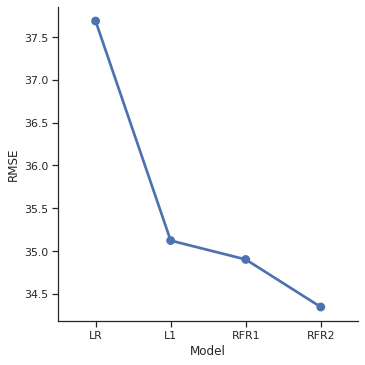

In [96]:
sns.catplot(x="Model", y="RMSE", linestyles=["-"],
            kind="point", data=rmsedf);

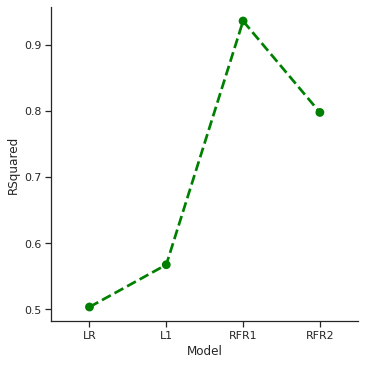

In [97]:
sns.catplot(x="Model", y="RSquared", linestyles=["--"], color ="green", kind="point", data=rsqdt);